In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from kneed import KneeLocator
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo

imputer = KNNImputer(n_neighbors=5)


In [2]:
# reversed indicators
reversed = ['Unemployment, total (% of total labor force) (modeled ILO estimate)',
            'Mortality rate, under-5 (per 1,000 live births)',
            'CO2 emissions (metric tons per capita)']
# sub indexes
education = [ 'Unemployment, total (% of total labor force) (modeled ILO estimate)',
              'School enrollment, secondary (% net)',
              'School enrollment, primary (% net)',
              'School enrollment, tertiary (% gross)']
economic = ['World Development Indicators',
            'Access to electricity (% of population)',
            'GDP per capita (current US$)']
health = ['Mortality rate, under-5 (per 1,000 live births)',
          'Life expectancy at birth, total(years)']
environment = ['CO2 emissions (metric tons per capita)']
security = ['Democracy index',
            'Control of Corruption: Estimate',
            'Government Effectiveness: Estimate',
            'Political Stability and Absence of Violence/Terrorism: Estimate',
            'Regulatory Quality: Estimate',
            'Rule of Law: Estimate',
            'Voice and Accountability: Estimate']
list_of_sub_indexes = [education, economic, environment, health, security]
sub_indexes = ['Education', 'Economic', 'Health', 'Environment', 'Safety']

In [3]:
list_of_dfs = []
def convert_separate(year):
    data = pd.read_csv(f'DS_Index - {year}.csv')
    # safety index cleaning
    safety = pd.read_excel("Safety.xlsx")
    names = ['Control of Corruption: Estimate', 'Government Effectiveness: Estimate', 'Political Stability and Absence of Violence/Terrorism: Estimate', 'Regulatory Quality: Estimate', 'Rule of Law: Estimate', 'Voice and Accountability: Estimate']
    safety = safety[safety['Series Name'].isin(names)]
    # merging data
    for i in range(len(names)):
        s = safety[safety['Series Name'] == names[i]][['Country Code', f'{year} [YR{year}]']]
        col = s.columns.tolist()
        col[-1] = names[i]
        s.columns = col
        data = data.merge(s, on=['Country Code'])

    # deleting unnecessary information
    to_delete = ['Rail lines (total route-km)', 'Net migration', 'Annual freshwater withdrawals, total (% of internal resources)']
    data.drop(labels=to_delete, inplace=True, axis=1)

    # converting to float
    data.replace('..', np.nan, inplace=True)
    cols = data.columns
    cols = cols[2:]
    data[cols] = data[cols].astype(str)
    data = data.apply(lambda x: x.str.replace(',','.'))
    data[cols] = data[cols].astype(float)

    #remove rows with more than 3 NaN
    data = data[data.isnull().sum(axis=1) < 3]
    data.reset_index(inplace=True, drop=True)


    # filling missing values with KNN, k = 5
    data[cols] = pd.DataFrame(imputer.fit_transform(data[cols]),columns = cols)

    # normalizing data
    data[cols]=(data[cols]-data[cols].min())/(data[cols].max()-data[cols].min())
    for i in reversed:
        data[i] = 1 - data[i]

    # factorizing security
    fa_s = FactorAnalyzer(rotation='varimax')
    fa_s.fit(data[security])
    # processing loadings
    loadings = pd.DataFrame(fa_s.loadings_)
    loadings = loadings.apply(lambda x: x*x)
    loadings = loadings.apply(lambda column: column/column.sum(), axis=0)
    # creating temporary intermediate indicators
    for i in loadings.columns:
        data[str(i)] = 0
        index = 0
        for weight in loadings[i]:
            if weight > 0.1:
                data[str(i)] += weight*data[security[index]]
            index += 1
    expl_var = fa_s.get_factor_variance()[0]

    # computing sub indexes and index
    data['Economic'] = data[economic].mean(axis=1)
    data['Environment'] = data[environment].mean(axis=1)
    data['Education'] = (data[education[0]]*0.5 + (data[education[1]]*0.5/3 + data[education[2]]*0.5/3 + data[education[3]]*0.5/3))
    data['Health'] = (data[health[0]]*0.3 + data[health[1]]*0.7)
    data['Safety'] = 0
    for i in loadings.columns:
        coef = expl_var[i]/ expl_var.sum()
        data['Safety'] += data[str(i)] * coef

    # drop temporary indicators
    data.drop(labels = [str(i) for i in loadings.columns], axis=1, inplace=True)

    coef_for_environment = 0.1
    coef_for_others = (1 - coef_for_environment)/(len(list_of_sub_indexes)-1)

    data['Prosperity index'] = data['Environment'] * coef_for_environment + coef_for_others * (data['Economic'] + data['Education'] + data['Health'] + data['Safety'])

    #loading to excel normalized version with indexes
    data.to_excel(f"{year}.xlsx")

    data.sort_values('Prosperity index', inplace=True, ascending=False)

    #loading result to excel
    res = data[['Country Name', 'Country Code'] + sub_indexes + ['Prosperity index']].reset_index(drop=True)
    res.index += 1
    res.reset_index(names="Rank", inplace = True)
    res.index += 1
    res.to_excel(f"{year}result.xlsx")

    data.reset_index(inplace=True, drop=True)
    data.index += 1
    data.reset_index(inplace=True, names='Rank')
    data.index += 1
    data = pd.concat([data], keys=[f'{year}'], names=['Year'])
    list_of_dfs.append(data)



In [4]:
years = [x for x in range(2015, 2021)]
for i in years:
    convert_separate(i)

result = pd.concat(list_of_dfs)
result.to_excel('result.xlsx')
result[['Country Name', 'Country Code'] + sub_indexes + ['Prosperity index']].to_excel("result_indexes.xlsx")


# Testing for 2015

In [5]:
year = 2015
data = pd.read_csv(f'DS_Index - {year}.csv')
# safety index cleaning
safety = pd.read_excel("Safety.xlsx")
names = ['Control of Corruption: Estimate', 'Government Effectiveness: Estimate', 'Political Stability and Absence of Violence/Terrorism: Estimate', 'Regulatory Quality: Estimate', 'Rule of Law: Estimate', 'Voice and Accountability: Estimate']
safety = safety[safety['Series Name'].isin(names)]
# merging data
for i in range(len(names)):
    s = safety[safety['Series Name'] == names[i]][['Country Code', f'{year} [YR{year}]']]
    col = s.columns.tolist()
    col[-1] = names[i]
    s.columns = col
    data = data.merge(s, on=['Country Code'])

# deleting unnecessary information
to_delete = ['Rail lines (total route-km)', 'Net migration', 'Annual freshwater withdrawals, total (% of internal resources)']
data.drop(labels=to_delete, inplace=True, axis=1)

# converting to float
data.replace('..', np.nan, inplace=True)
cols = data.columns
cols = cols[2:]
data[cols] = data[cols].astype(str)
data = data.apply(lambda x: x.str.replace(',','.'))
data[cols] = data[cols].astype(float)

#remove rows with more than 3 NaN
data = data[data.isnull().sum(axis=1) < 3]
data.reset_index(inplace=True, drop=True)


# filling missing values with KNN, k = 5
data[cols] = pd.DataFrame(imputer.fit_transform(data[cols]),columns = cols)

# normalizing data
data[cols]=(data[cols]-data[cols].min())/(data[cols].max()-data[cols].min())
for i in reversed:
    data[i] = 1 - data[i]

# cluster analysis
clusters_data = data.drop(labels=['Country Name', 'Country Code'], axis=1)

#determining number of clusters
numClusters = [i for i in range(1, 11)]
SSE = []
for k in numClusters:
    k_means = KMeans(init='random', n_clusters=k, max_iter=50, random_state=1, n_init=10)
    k_means.fit(clusters_data)
    SSE.append(k_means.inertia_)

kl = KneeLocator(range(1, 11), SSE, curve="convex", direction="decreasing")
number_of_clusters = kl.elbow
k_means = KMeans(init='random', n_clusters=number_of_clusters, max_iter=50, random_state=1, n_init=10)
k_means.fit(clusters_data)
labels = k_means.labels_
clusters = pd.DataFrame(labels, index=data['Country Name'], columns=['Cluster ID'])
#print countries in clusters
for i in range(number_of_clusters):
    print(f"Cluster {i}:")
    print(clusters[clusters['Cluster ID'] == i].index)


C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. 

Cluster 0:
Index(['Australia', 'Austria', 'Belgium', 'Bahamas. The', 'Barbados', 'Canada',
       'Switzerland', 'Chile', 'Costa Rica', 'Cyprus', 'Czechia', 'Germany',
       'Denmark', 'Spain', 'Estonia', 'Finland', 'France', 'United Kingdom',
       'Hong Kong SAR. China', 'Ireland', 'Iceland', 'Israel', 'Italy',
       'Japan', 'Korea. Rep.', 'Lithuania', 'Luxembourg', 'Latvia', 'Malta',
       'Mauritius', 'Netherlands', 'Norway', 'New Zealand', 'Poland',
       'Puerto Rico', 'Portugal', 'Slovenia', 'Sweden', 'Uruguay',
       'United States'],
      dtype='object', name='Country Name')
Cluster 1:
Index(['Albania', 'United Arab Emirates', 'Argentina', 'Armenia', 'Azerbaijan',
       'Bulgaria', 'Bahrain', 'Bosnia and Herzegovina', 'Belarus', 'Belize',
       'Bolivia', 'Brazil', 'Brunei Darussalam', 'Bhutan', 'Botswana', 'China',
       'Colombia', 'Cabo Verde', 'Cuba', 'Dominican Republic', 'Algeria',
       'Ecuador', 'Egypt. Arab Rep.', 'Fiji', 'Georgia', 'Ghana', 'Greece',
   

# Visualizing clusters

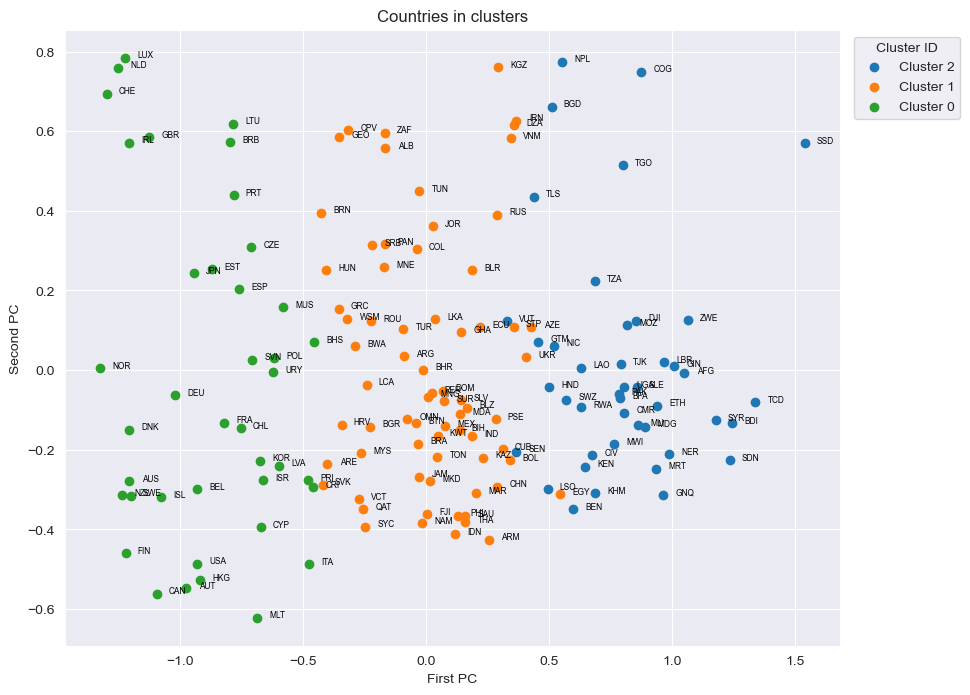

In [6]:
from sklearn.decomposition import PCA

data.reset_index(drop=True, inplace=True)
pca = PCA(n_components=2)
components = pca.fit_transform(data[cols])
comp = pd.DataFrame(components)
visual = data[['Country Name', 'Country Code']].join(comp)
visual = visual.merge(clusters, how='left', on='Country Name')

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
# Scatter plot with different colors for each cluster
for cluster_id in visual['Cluster ID'].unique():
    cluster_data = visual[visual['Cluster ID'] == cluster_id]
    plt.scatter(cluster_data[0], cluster_data[1], label=f'Cluster {cluster_id}')

    for index, row in cluster_data.iterrows():
        plt.text(row[0] + 0.05, row[1], row['Country Code'], fontsize=6, color='black')

# Add labels and title
plt.xlabel('First PC')
plt.ylabel('Second PC')
plt.title('Countries in clusters')

# Add legend
plt.legend(title='Cluster ID', bbox_to_anchor=(1.01, 1), loc='upper left')

plt.show()

# Factorizing

In [7]:
l = []
# finding "factorizable" sub_indexes
for i in list_of_sub_indexes:
    if len(i) > 1:
        kmo_all,kmo_model=calculate_kmo(data[i])
        if kmo_model > 0.7:
            print(kmo_model)
            l.append(i)
l

0.8527595986108871


C:\ProgramData\anaconda3\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


[['Democracy index',
  'Control of Corruption: Estimate',
  'Government Effectiveness: Estimate',
  'Political Stability and Absence of Violence/Terrorism: Estimate',
  'Regulatory Quality: Estimate',
  'Rule of Law: Estimate',
  'Voice and Accountability: Estimate']]

In [8]:
# factorizing security
fa_s = FactorAnalyzer(rotation='varimax')
fa_s.fit(data[security])
# processing loadings
loadings = pd.DataFrame(fa_s.loadings_)
loadings = loadings.apply(lambda x: x*x)
loadings = loadings.apply(lambda column: column/column.sum(), axis=0)
# creating temporary intermediate indicators
for i in loadings.columns:
    data[str(i)] = 0
    index = 0
    for weight in loadings[i]:
        if weight > 0.1:
            data[str(i)] += weight*data[security[index]]
        index += 1
expl_var = fa_s.get_factor_variance()[0]

# computing sub indexes and index
data['Economic'] = data[economic].mean(axis=1)
data['Environment'] = data[environment].mean(axis=1)
data['Education'] = (data[education[0]]*0.5 + (data[education[1]]*0.5/3 + data[education[2]]*0.5/3 + data[education[3]]*0.5/3))
data['Health'] = (data[health[0]]*0.3 + data[health[1]]*0.7)
data['Safety'] = 0
for i in loadings.columns:
    coef = expl_var[i]/ expl_var.sum()
    data['Safety'] += data[str(i)] * coef

# drop temporary indicators
data.drop(labels = [str(i) for i in loadings.columns], axis=1, inplace=True)

coef_for_environment = 0.1
coef_for_others = (1 - coef_for_environment)/(len(list_of_sub_indexes)-1)

data['Prosperity index'] = data['Environment'] * coef_for_environment + coef_for_others * (data['Economic'] + data['Education'] + data['Health'] + data['Safety'])

#loading to excel normalized version with indexes
data.to_excel(f"test{year}.xlsx")

data.sort_values('Prosperity index', inplace=True, ascending=False)

#loading result to excel
res = data[['Country Name', 'Country Code'] + sub_indexes + ['Prosperity index']].reset_index(drop=True)
res.index += 1
res.reset_index(names="Rank", inplace = True)
res.index += 1
res.to_excel(f"test{year}result.xlsx")

In [9]:
res

,Rank,Country Name,Country Code,Education,Economic,Health,Environment,Safety,Prosperity index
1,1,Iceland,ISL,0.847960,0.685461,0.888550,0.879652,0.688766,0.787881
2,2,Hong Kong SAR. China,HKG,0.839115,0.636897,0.967071,0.843174,0.652936,0.780922
3,3,New Zealand,NZL,0.838726,0.634869,0.792880,0.975392,0.746198,0.775391
4,4,Sweden,SWE,0.791985,0.681395,0.795996,0.833961,0.734274,0.759217
5,5,Australia,AUS,0.874232,0.680399,0.742482,0.841534,0.698900,0.758256
...,...,...,...,...,...,...,...,...,...
150,150,Sudan,SDN,0.342927,0.323884,0.877536,0.559629,0.079087,0.421235
151,151,Djibouti,DJI,0.173905,0.405123,0.691086,0.936669,0.184889,0.421043
152,152,Nepal,NPL,0.533644,0.454028,0.176413,0.995981,0.246601,0.417002
153,153,Congo. Rep.,COG,0.323841,0.270804,0.243658,0.999804,0.157382,0.324010


In [23]:
loadings

,0,1,2
0,0.054645,0.292403,0.033071
1,0.172397,0.065900,0.296083
2,0.221683,0.058682,0.112252
3,0.078954,0.066092,0.261657
4,0.226378,0.091015,0.016819
5,0.205569,0.079453,0.170291
6,0.040375,0.346456,0.109826


# Visualizing correlations

In [15]:
data.columns

Index(['Country Name', 'Country Code',
       'Unemployment, total (% of total labor force) (modeled ILO estimate)',
       'School enrollment, secondary (% net)',
       'School enrollment, primary (% net)',
       'School enrollment, tertiary (% gross)', 'World Development Indicators',
       'Access to electricity (% of population)',
       'GDP per capita (current US$)',
       'Mortality rate, under-5 (per 1,000 live births)',
       'Life expectancy at birth, total(years)',
       'CO2 emissions (metric tons per capita)', 'Democracy index',
       'Control of Corruption: Estimate', 'Government Effectiveness: Estimate',
       'Political Stability and Absence of Violence/Terrorism: Estimate',
       'Regulatory Quality: Estimate', 'Rule of Law: Estimate',
       'Voice and Accountability: Estimate', 'Economic', 'Environment',
       'Education', 'Health', 'Safety', 'Prosperity index'],
      dtype='object')

In [17]:
data.rename(columns = {'Unemployment, total (% of total labor force) (modeled ILO estimate)' : 'Unemployment',
    'School enrollment, secondary (% net)' : 'Secondary school',
    'School enrollment, primary (% net)': 'Primary school',
    'School enrollment, tertiary (% gross)': 'Tertiary school'}, inplace = True)

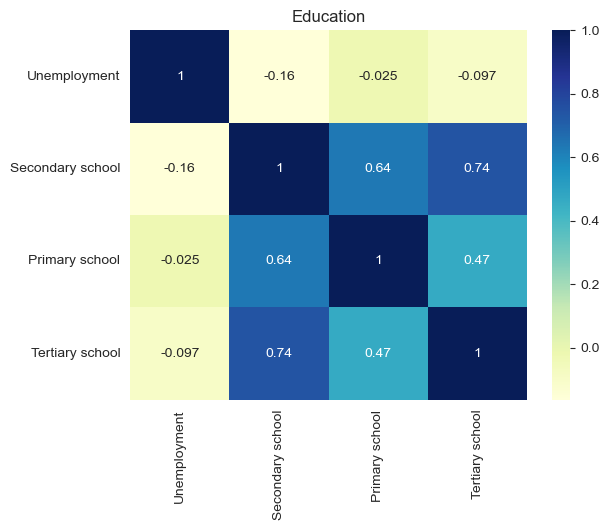

In [20]:
import seaborn as sb

dataplot = sb.heatmap(data[['Unemployment', 'Secondary school', 'Primary school','Tertiary school']].corr(), cmap="YlGnBu", annot=True)

plt.title('Education')
plt.show()

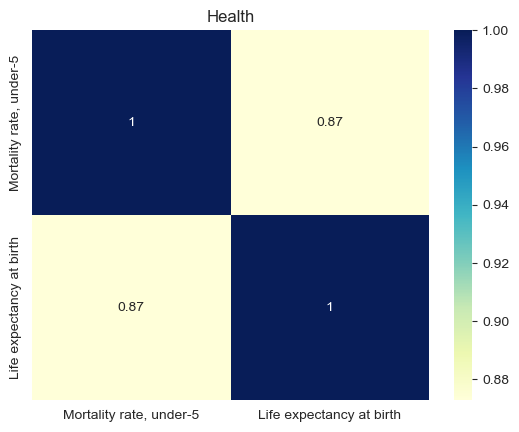

In [22]:
data.rename(columns = {'Mortality rate, under-5 (per 1,000 live births)': 'Mortality rate, under-5',
                       'Life expectancy at birth, total(years)': 'Life expectancy at birth'}, inplace = True)

dataplot = sb.heatmap(data[['Mortality rate, under-5', 'Life expectancy at birth']].corr(), cmap="YlGnBu", annot=True)

plt.title('Health')
plt.show()

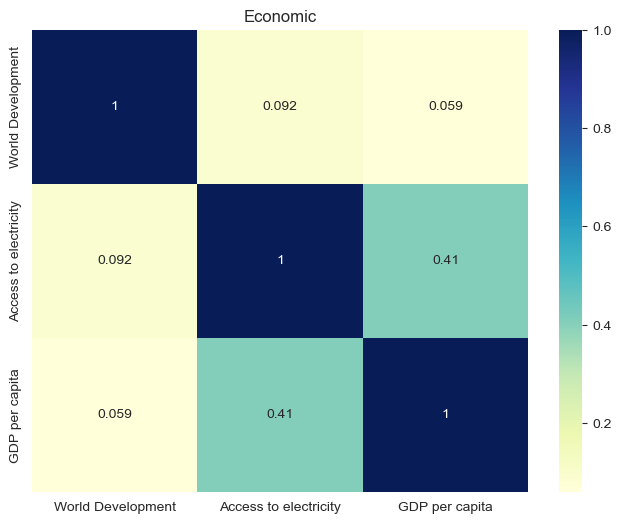

In [26]:
data.rename(columns = {'World Development Indicators' : 'World Development',
                       'Access to electricity (% of population)' : 'Access to electricity',
                       'GDP per capita (current US$)': 'GDP per capita'}, inplace = True)

plt.figure(figsize=(8, 6))
dataplot = sb.heatmap(data[['World Development','Access to electricity','GDP per capita']].corr(), cmap="YlGnBu", annot=True)

plt.title('Economic')
plt.show()

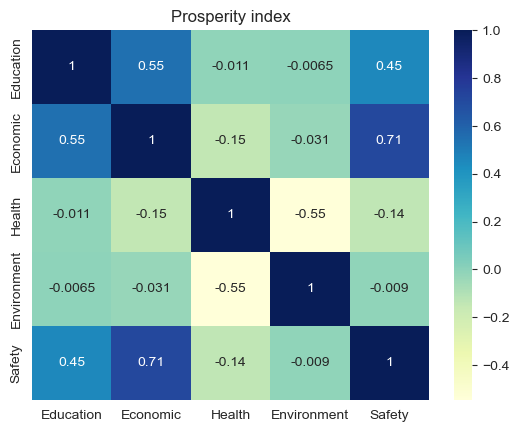

In [27]:
dataplot = sb.heatmap(data[sub_indexes].corr(), cmap="YlGnBu", annot=True)

plt.title('Prosperity index')
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


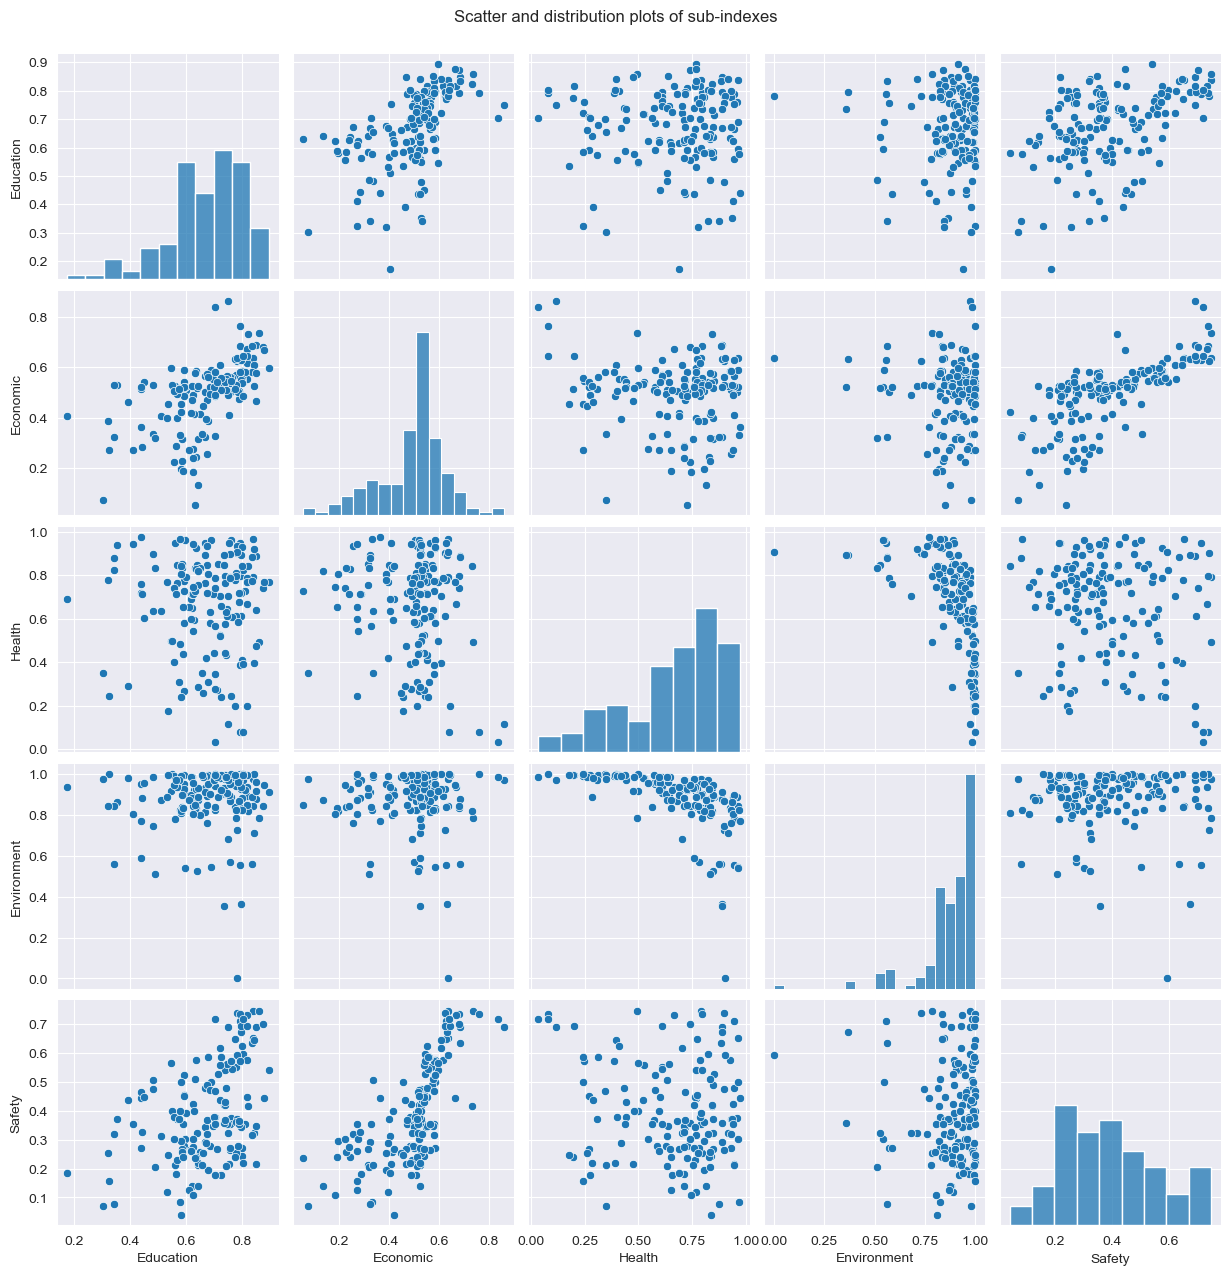

In [30]:
# Pair plot using Seaborn
sb.pairplot(data[sub_indexes])
plt.suptitle('Scatter and distribution plots of sub-indexes', y=1.02)
plt.show()